In [18]:
import netCDF4
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from utils.image_transform import crop_center_square, transform_color, resize_image
from patchify import patchify
from datetime import timedelta
import pandas as pd

In [2]:
ir_dir = 'E:/polar/code/data/flight9/IRdata_ATWAICE_processed_220718_142920.nc'
#### Convert netcdf data to numpy array ####
ds = netCDF4.Dataset(ir_dir)
imgs = ds.variables['Ts'][:]
timestamps = ds.variables['time'][:]

In [2]:
# flight 16
ir_dir_16 = 'E:/polar/code/data/flight16/IRdata_ATWAICE_processed_220730_111439.nc'
#### Convert netcdf data to numpy array ####
ds_16 = netCDF4.Dataset(ir_dir)
imgs_16 = ds.variables['Ts'][:]
timestamps_16 = ds.variables['time'][:]

In [19]:
def extract_time(img_idx, timestamps, flight_nr):
    """
    Convert the timestamp for an image.

    Parameters:
    ----------
        img_idx : int
        timestamps : numpy.ma.core.MaskedArray
    """
    
    if flight_nr == 9:
        reference = '2022-07-18 00:00:00'
    elif flight_nr == 16:
        reference = '2022-07-30 00:00:00'

    times = pd.Series(timestamps)
    date = pd.Timestamp(reference)
    time = str(date + timedelta(seconds=int(times[img_idx])))

    return time

In [23]:
def extract_single(dataset, idx, time, flight_nr, save_path):
    # extracts image in squared shape

    timestamp = extract_time(idx, time, flight_nr).replace(' ','_').replace(':','').replace('-','')
    img = dataset[idx]
    img = crop_center_square(img)

    # clip for better visibility, use 272,274 for flight 16
    img = np.clip(img, 272.5, 274)
    plt.imshow(img)

    plt.imsave(os.path.join(save_path, '{}_{}.png'.format(timestamp,idx)), img, cmap='cividis')

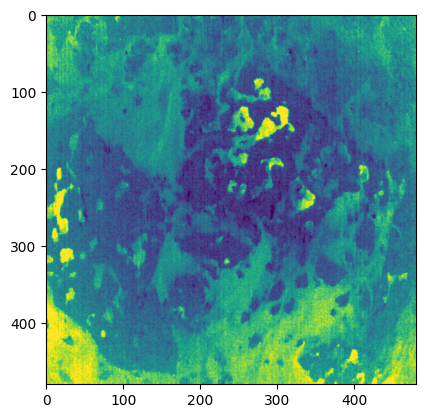

In [24]:
extract_single(imgs, 100, timestamps, 16, 'E:/polar/code/ponds_extended_data/candidates')

In [3]:
#### this chunk is used to save the arrays directly
imgs_train = [imgs[2416],imgs[2380],imgs[2424],imgs[2468],imgs[2476],imgs[2708],imgs[3700],imgs[3884], imgs[4568], imgs[1104]]

tmp = []

# prepare the training data: crop center square and store and .png file
for im in imgs_train:
    im = crop_center_square(im)
    tmp.append(im)

imgs_train = tmp

imgs = np.array(imgs_train)

np.save('E:/polar/code/data/ir/entire/original_size/ims_raw_np/480_im_extended.npy', imgs)

In [4]:
### will prepare the extended training data set (test data remains the same)

mask_dir = 'E:/polar/code/data/ir/entire/original_size/msks_extended'

imgs_train = [imgs[2416],imgs[2380],imgs[2424],imgs[2468],imgs[2476],imgs[2708],imgs[3700],imgs[3884], imgs[4568], imgs[1104]]

tmp = []

# prepare the training data: crop center square and store and .png file
for im in imgs_train:
    im = crop_center_square(im)
    tmp.append(im)

imgs_train = tmp

# for experimenting with clipped temperature values (did not make a difference in model performance)
for idx, img in enumerate(imgs_train):
    plt.imsave('E:/polar/code/data/ir/entire/original_size/ims_raw_normalize_extended/{}.png'.format(idx), img, cmap='gray', 
               vmin=273, vmax=277)
    
for idx, img in enumerate(imgs_train):
    plt.imsave('E:/polar/code/data/ir/entire/original_size/ims_raw_extended/{}.png'.format(idx), img, cmap='gray')


# prepare masks: transform color values to class values, resize image, crop center square
masks_train = []
for f in os.listdir(mask_dir):
    path = os.path.join(mask_dir, f)
    mask = cv2.imread(path, 0)
    mask = transform_color(mask)
    mask = resize_image(mask)
    mask = crop_center_square(mask)

    masks_train.append(mask)

imgs = np.array(imgs_train)
masks = np.array(masks_train)

# save temperature values as np arrays (not used in final experiment due to bad performance in initial runs)
#np.save('E:/polar/code/data/ir/entire/original_size/prepared/480_im.npy', imgs)
#np.save('E:/polar/code/data/ir/entire/original_size/prepared/480_ma.npy', masks)

imgs_png = []
save_path = 'E:/polar/code/data/ir/entire/original_size/ims_raw_extended/'

imgs_png_norm = []
save_path_norm = 'E:/polar/code/data/ir/entire/original_size/ims_raw_normalize_extended/'

for im in os.listdir(save_path):
    path = os.path.join(save_path, im)
    im = cv2.imread(path, 0)
    im = crop_center_square(im)

    imgs_png.append(im)

for im in os.listdir(save_path_norm):
    path = os.path.join(save_path_norm, im)
    im = cv2.imread(path, 0)
    im = crop_center_square(im)

    imgs_png_norm.append(im)

imgs_raw = np.array(imgs_png)
masks_raw = np.array(masks_train)

imgs_raw_norm = np.array(imgs_png_norm)

# save as numpy arrays
np.save('E:/polar/code/data/ir/entire/original_size/ims_raw_np/480_im_extended.npy', imgs_raw)
np.save('E:/polar/code/data/ir/entire/original_size/ims_raw_np/480_ma_extended.npy', masks_raw)

# save normalized images as array
np.save('E:/polar/code/data/ir/entire/original_size/ims_raw_np/480_im_norm_extended.npy', imgs_raw_norm)